## **Calculating the AMOC in latitude-depth coordinates**

### **Description**

Recipe showing how to calculate the Atlantic Meridional Overturning Stream Function in depth-coordinates using annual-mean outputs from the National Oceanography Centre Near-Present-Day global eORCA1 configuration of NEMO forced using JRA55-do from 1976-2024.

For more details on this model configuration and the available outputs, users can explore the Near-Present-Day documentation [here](https://noc-msm.github.io/NOC_Near_Present_Day/).

In [1]:
# -- Import required Python packages -- #
import xarray as xr
import matplotlib.pyplot as plt

# -- Import nemo_cookbook tools -- #
from nemo_cookbook import compute_moc_z

### **Using Dask**

**Optional: Connect Client to Dask Local Cluster to run analysis in parallel.**

Note that, although using Dask is not strictly necessary for this simple example using eORCA1, if we wanted to generalise this recipe to eORCA025 or eORCA12 outputs, using Dask would be essential to avoid unnecessary slow calculations using only a single process.

In [ ]:
# -- Initialise Dask Local Cluster -- #
import dask
from dask.distributed import Client, LocalCluster

# Update temporarty directory for Dask workers:
dask.config.set({'temporary_directory': '/home/otooth/work/Diagnostics/proj_NPD_diag/nemo_cookbook/recipes',
                 'local_directory': '/home/otooth/work/Diagnostics/proj_NPD_diag/nemo_cookbook/recipes'
                 })

# Create Local Cluster:
cluster = LocalCluster(n_workers=4, threads_per_worker=5, memory_limit='5GB')
client = Client(cluster)
client

### **Preparing NEMO Model Data**
**Let's begin by loading the grid variables for our eORCA1 NEMO model from the [JASMIN Object Store](https://help.jasmin.ac.uk/docs/short-term-project-storage/using-the-jasmin-object-store/)**. 

**Alternatively, you can replace the ``domain_filepath`` below with a file path to your domain_cfg.nc file and read this with xarray's ``open_dataset()`` function.**

In [ ]:
# Define directory path to ancillary files:
domain_filepath = "https://noc-msm-o.s3-ext.jc.rl.ac.uk/npd-eorca1-jra55v1/domain"

# Open eORCA1 model grid data:
ds_domain = xr.open_zarr(domain_filepath, consolidated=True, chunks={})

# Extract zonal grid cell widths (m):
e1v = ds_domain['e1v'].squeeze()
# Extract Atlantic Ocean mask:
atl_mask = ds_domain['atlmsk'].squeeze()

**Next, we need to import the meridional velocity field and vertical grid cell thickness**

In [ ]:
# Define directory path to model output files:
output_dir = "https://noc-msm-o.s3-ext.jc.rl.ac.uk/npd-eorca1-jra55v1"

# Extract vertical grid cell thicknesses (m):
e3v = xr.open_zarr(f"{output_dir}/V1y/e3v", consolidated=True, chunks={})['e3v']
# Extract meridional velocities (m/s):
vo = xr.open_zarr(f"{output_dir}/V1y/vo", consolidated=True, chunks={})['vo']


### **Calculating Vertical Overturning Stream Function**

**Now all our input variables are ready, let's calculate the Atlantic Meridional Overturning Stream Function in depth-coordinates**

In [ ]:
# Apply the Atlantic Ocean sector mask:
moc_z_atl = compute_moc_z(vo=vo, e1v=e1v, e3v=e3v, mask=atl_mask)

moc_z_atl

<xarray.DataArray 'moc_z' (time_counter: 48, depthv: 75, y: 331)> Size: 10MB
dask.array<nancumsum, shape=(48, 75, 331), dtype=float64, chunksize=(1, 25, 331), chunktype=numpy.ndarray>
Coordinates:
  * depthv         (depthv) float32 300B 0.5058 1.556 ... 5.698e+03 5.902e+03
    time_centered  (time_counter) datetime64[ns] 384B 1976-07-02 ... 2023-07-...
  * time_counter   (time_counter) datetime64[ns] 384B 1976-07-02 ... 2023-07-...
Dimensions without coordinates: y
Attributes:
    units:          Sv
    long_name:      meridional overturning stream function in depth coordinates
    standard_name:  moc_z

**Notice that the output above is a dask array, so we haven't actually computed the vertical overturning yet. To do this, we need to call the ``.compute()`` method:**

In [ ]:
moc_z_atl = moc_z_atl.compute()

### **Visualising Vertical Overturning Stream Function**

**Finally, let's visualise the results by plotting the time-mean Atlantic Meridional Overturning Stream Function in depth-coordinates:**

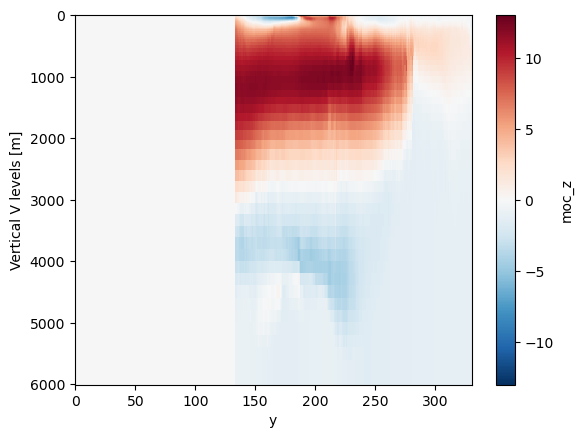

In [ ]:
moc_z_atl.mean(dim='time_counter').plot(yincrease=False)